**Author:** Summer </br>
**Task:** 2D footprint clustering (exterior boundaries of building footprints)

## PART I: Skeleton Graph Computation
### **Step 1: Medial Axis Approximation (Approach 4 Point reduction and edge construction in step 1, scikit geometry in step 2)**
### ***Ext. Boundaries***

**1.1 Load data and plot edges and points**

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import unary_union
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance
import ot

In [26]:
# load raw data
buildings_ext_raw = gpd.read_file("./data/input/529E_ext_bound/529E_ext_bound.shp")
buildings_ext_raw

,stories,materials,blockID,height(m),geometry
0,2,frame or wood,630,NaN,"POLYGON ((-9233563.682 4859388.217, -9233563.4..."
1,2,concrete and cinder block,1974_1,NaN,"POLYGON ((-9233450.127 4859373.974, -9233449.5..."
2,1,frame or wood,2010_1,NaN,"POLYGON ((-9233348.309 4859371.8, -9233347.519..."
3,2,frame or wood,636,NaN,"POLYGON ((-9233558.67 4859376.354, -9233559.59..."
4,1,frame or wood,1956_kento,NaN,"POLYGON ((-9233502.187 4859368.688, -9233501.8..."
...,...,...,...,...,...
332,None,brick or tile,R.808,3.6576,"POLYGON ((-9233811.121 4858828.158, -9233786.3..."
333,None,None,1826,10.0584,"POLYGON ((-9233824.192 4858655.628, -9233794.9..."
334,None,None,1826,15.2400,"POLYGON ((-9233833.089 4858552.073, -9233803.6..."
335,1,brick or tile,1826_1,NaN,"POLYGON ((-9233783.715 4858535.96, -9233777.99..."


In [55]:
# dissolve multipart polygons
buildings_ext_raw_boundary = buildings_ext_raw[["blockID", "geometry"]]
buildings_ext_raw_boundary["geometry"] = buildings_ext_raw_boundary.buffer(0.1)
buildings_ext_boundary_diss = buildings_ext_raw_boundary.dissolve(by="blockID")
buildings_ext_boundary_diss

/home/summerha/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry
blockID,
1826,"POLYGON ((-9233833.187 4858552.09, -9233833.18..."
1826_1,"POLYGON ((-9233783.814 4858535.969, -9233783.8..."
1869,"POLYGON ((-9233783.642 4859312.213, -9233783.6..."
1882-84,"POLYGON ((-9233632.903 4858483.358, -9233632.9..."
1882-84_1,"POLYGON ((-9233624.734 4858532.58, -9233624.73..."
...,...
E.L.2060,"POLYGON ((-9233241.372 4858489.717, -9233241.3..."
E.L.2070,"POLYGON ((-9233200.408 4858445.929, -9233200.4..."
R.808,"POLYGON ((-9233787.89 4858808.688, -9233787.89..."


In [ ]:
buildings_ext_boundary_diss.explore()

In [ ]:
#buildings_ext_boundary_diss.to_file("./data/output/multipart_ext_bound.shp", driver="ESRI Shapefile")

In [28]:
# placing points on the vertices where an edge changes direction, constructing edges between vertices
def sample_points_at_vertices(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    all_vertex_points = []
    all_edges = []

    for idx, row in gdf.iterrows():
        geom = row.geometry # extracts the geometry (i.e., building footprint) from the row in the gdf

        # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
        if geom is None or not isinstance(geom, (Polygon, MultiPolygon)):
            print(idx)
            print(geom)
            continue

        # if the geometry is a multipolygon, merge them into a single polygon
        if isinstance(geom, MultiPolygon):
            geom = unary_union(geom)

        exterior_coords = list(geom.exterior.coords) # get the coordinates of the outer boundary of the polygon, in a sequence of (x,y) tuples
        coords = exterior_coords[:-1]
        vertex_points = [Point(xy) for xy in exterior_coords[:-1]]  # convert each (x,y) coordinate into a Point object, exclude the last coordinate since it duplicates the first (to close the polygon)
        all_vertex_points.extend(vertex_points) # add all the Point objects of a polygon to the list all_vertex_points

        # Create edges between consecutive vertices
        edges = [LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        # Add edge between the last and first to close the polygon
        edges.append(LineString([coords[-1], coords[0]]))

        all_edges.extend(edges)

    # Return GeoDataFrames for points and edges
    points_gdf = gpd.GeoDataFrame(geometry=all_vertex_points, crs=gdf.crs)
    edges_gdf = gpd.GeoDataFrame(geometry=all_edges, crs=gdf.crs)

    return gdf, points_gdf, edges_gdf

In [29]:
# load building footprint for cleaning - ext boundaries
buildings_ext_gdf, points_ext_gdf, edges_ext_gdf = sample_points_at_vertices("./data/output/multipart_ext_bound.shp")

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(24, 24))
edges_ext_gdf.plot(ax=ax, edgecolor='blue', linewidth=1, facecolor='none')
points_ext_gdf.plot(ax=ax, color='red', markersize=3)
plt.savefig("./data/output/for_ext_bound_vetices_edges_reduced_points.png", dpi=1200, bbox_inches='tight')
plt.show()

**1.2 Medial axis construction**

In [292]:
import skgeom as sg
from skgeom.draw import draw

In [293]:
def draw_skeleton(polygon, skeleton, show_time=False):
    draw(polygon)

    for h in skeleton.halfedges:
        if h.is_bisector:
            p1 = h.vertex.point
            p2 = h.opposite.vertex.point
            plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=2)

    if show_time:
        for v in skeleton.vertices:
            plt.gcf().gca().add_artist(plt.Circle(
                (v.point.x(), v.point.y()),
                v.time, color='blue', fill=False))

In [294]:
print(type(buildings_ext_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [295]:
all_poly = []
all_skeleton = []

for idx, row in buildings_ext_gdf.iterrows():
    geom = row.geometry
    #print(geom)

    # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
    if geom is None or not isinstance(geom, (Polygon, MultiPolygon)): 
        print(idx)
        print(geom)
        continue

    # continue to work with geom that is not null
    # for each geom, extract the points and convert them to sg.Point2; use the points to create and draw poly; create the skeleton for each geom
    points = []
    for x,y in geom.boundary.coords[:-1]: # [:-1] to exclude the last point that is used to close the polygon
        points.append(sg.Point2(x,y))
         
    poly = sg.Polygon(points[::-1]) # reverse order of the points    
    all_poly.append(poly)
    skel = sg.skeleton.create_interior_straight_skeleton(poly)        
    all_skeleton.append(skel)

#print(idx)
#print(all_poly)
#len(all_poly)

In [ ]:
plt.figure(figsize=(24,24))
draw(all_poly, plt=plt, line_width=0.5)

In [301]:
def draw_all_skeletons(polygon, all_skeletons, show_time=False, figsize=(24,24)):
    plt.figure(figsize=figsize)
    draw(polygon, line_width=0.5)
    
    for item in all_skeletons:

        if item is None:
            continue
        
        for h in item.halfedges:
            if h.is_bisector:
                p1 = h.vertex.point
                p2 = h.opposite.vertex.point
                plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=0.5)

        if show_time:
            for v in skeleton.vertices:
                plt.gcf().gca().add_artist(plt.Circle(
                    (v.point.x(), v.point.y()),
                    v.time, color='blue', fill=False))
    return plt

In [ ]:
for idx, x in enumerate(all_skeleton):
    if x == None:
        print(idx, x)

In [ ]:
draw_all_skeletons(all_poly,all_skeleton)
plt.savefig("./data/output/ext_bound_scikit_geom.png", dpi=1200, bbox_inches='tight')

## PART II: Clustering

**2.1 Graph Embedding and Weisfeiler-Lehman Label Propagation** </br>
**2.2 Graph Wasserstein Distance using Optimal Transport Theory**

In [362]:
## Medial axis construction
### function #1: Extract poitns from one polygon
def pts_to_skeleton(geom):
    '''
    This function extracts points from a geometry, converts them into a polygon, and draws the skeleton of a geometry. It returns a skeleton graph of a geometry
    '''
    points = []
    for x, y in geom.boundary.coords[:-1]:
        points.append(sg.Point2(x,y))
    points_to_poly = points[::-1] # make sure it is counter-clockwise
    poly_to_skel = sg.Polygon(points_to_poly)
    skeleton = sg.skeleton.create_interior_straight_skeleton(poly_to_skel)
    return skeleton


### function #2: Convert skeleton graphs to networkx graphs
def skeleton2networkx(skeleton):
    geom_vertices = list(skeleton.vertices)
    geom_edges = list(skeleton.halfedges)

    # create an empty graph with no nodes and no edges
    G=nx.Graph()

    # grow undirected (since it adds up from both direction) graph G by adding edge, done by specifying the vertex id at two ends to determine the edge
    for item in geom_edges:
        if item.is_bisector:
            p1 = item.vertex.id # vertex id
            p2 = item.opposite.vertex.id
            G.add_edge(p1, p2)
    #nx.draw(G, with_labels=True)
    return G


## Weisfeiler-Lehman label propagation
### function #3: Weisfeiler-Lehman label propagation
### This can be found directly from networkx function, `nx.weisfeiler_lehman_subgraph_hashes()`

## Graph embeddings
### function #4: # Create node embeddings of graph and convert list of list to matrix for the subsequent computation
def graph_embeddings(g_hash):
    g_node_features = []
    for i in g_hash.values():
        g_node_features.append(i)

    g_node_features_matrix = np.array(g_node_features)
    return g_node_features_matrix

## Wasserstein distance computation using optimal transport theory
### function #4: rho(x,y) define a rho function for 1, x not equal y; and 0, x equals y
def rho(x,y):
    '''
    This function is part of the dham eq. from Togninalli et al. (2019).
    In the nx.weisfeiler_lehman_subgraph_hashes() method, there is an argument to specify iteration(s) of label propagation.
    Each vertex is represented by a list of hex code. This function compares one iteration of the hex code in each vertex of X and that of in X'.
    '''
    if x == y:
        return 0
    else:
        return 1

### function #5: Compute the ground cost, M, between graphs
def ground_cost_m(graph1, graph2):
    '''
    This function is translated from the dham eq. from Togninalli et al. (2019)
    
    INPUT
    graph1: matrix of node features of a graph
    graph2: matrix of node features of another graph

    OUTPUT
    An array of distances between vertices in X and X'
    '''
    # create an empty matrix to store the info later
    M12 = np.zeros((len(graph1), len(graph2)))

    # compute M
    for index_i, v_i in enumerate(graph1): # row in graph 1
        for index_i_p, v_i_p in enumerate(graph2): # row in graph 2
            # this part computes dham
            constant =  1.0 / (len(v_i)+1) # computes the constant 1 / H + 1
            # this part computes the sum of rho
            sum_of_rho = 0
            for i in range(len(v_i)): # since begin from 0, so just the original length, no need to +1 (as suggested in the equation)
                sum_of_rho += rho(v_i[i],v_i_p[i])
                #print(sum_of_rho)
   
            ## this part times the constant with the summation of the rhos
            dham = constant*sum_of_rho # this is dham(v,v')

            M12[index_i,index_i_p] = dham
    return M12

### function #6: Vectorize a and b for Wasserstein distance computation
def od_vector(graph1_nf_m,graph2_nf_m):
    '''
    Computes a (origin) or b (destination), aka vertices in X (there is n # of vertices), 
    each vertex in G1 should be represented as 1/n and summed up to 1, 
    whereas each vertex in G2 should be represented as 1/n' and summed up to 1 as well

    INPUT
    
    '''
    n_g1 = np.full(graph1_nf_m.shape[0], 1/ graph1_nf_m.shape[0])
    n_g2 = np.full(graph2_nf_m.shape[0], 1/ graph2_nf_m.shape[0])
    return n_g1, n_g2


## THE BIG FUNCTION - from building.gdf to pairwise Wasserstein Distance
def bldgFootprint_pairwiseWassersteinDistance(buildingsgdf):
    '''
    This function takes building footprints, constructs the medial axis of each footprint, converts them into graph representations, 
    and computes the pairwise Wasserstein distances between each graph of building footprints
    
    INPUT
    buildingsgdf: Building footprints in gdf format

    OUTPUT
    Matrix of pairwise Wasserstein distances between graphs of building footprints
    '''
    # create an empty matrix to store the pairwise Wasserstein distances
    pairwiseWD = np.zeros((len(buildingsgdf), len(buildingsgdf)))
                          
    for i, geom1 in enumerate(buildingsgdf.geometry): 
        for j, geom2 in enumerate(buildingsgdf.geometry):
            # medial axis construction
            skeleton1 = pts_to_skeleton(geom1)
            skeleton2 = pts_to_skeleton(geom2)
            if skeleton1 == None or skeleton2 == None:
                #print(i, j)
                continue
            else:                
                # convert skeleton graphs to networkx graphs
                g1 = skeleton2networkx(skeleton1)
                g2 = skeleton2networkx(skeleton2)
                
                # Weisfeiler-Lehman label propagation
                g_hashes1 = nx.weisfeiler_lehman_subgraph_hashes(g1, iterations=4, digest_size=8)
                g_hashes2 = nx.weisfeiler_lehman_subgraph_hashes(g2, iterations=4, digest_size=8)
                
                #print(g_hashes)
                g_embeddings1 = graph_embeddings(g_hashes1)
                g_embeddings2 = graph_embeddings(g_hashes2)
                #print(f"G1:{g_embeddings1}; \nG2:{g_embeddings2}")

                # compute M
                m12 = ground_cost_m(g_embeddings1,g_embeddings2)

                # vectorize embedded graphs for Wasserstein distance computation
                n_g1, n_g2 = od_vector(g_embeddings1,g_embeddings2)

                # compute Wasserstein distance
                w_ab = ot.emd2(n_g1, n_g2, m12)

                pairwiseWD[i,j] = w_ab
                
    return pairwiseWD

In [ ]:
HV_529E_ext_bound_dist_m = bldgFootprint_pairwiseWassersteinDistance(buildings_ext_gdf)
print(HV_529E_ext_bound_dist_m)

Save the matrix as json so can load the json in and don't have to spend soooo long running chunk 17 before proceeding to spectral clustering.


In [305]:
import json

In [ ]:
# convert numpy array to a python list
HV_529E_ext_bound_dist_m_list = HV_529E_ext_bound_dist_m.tolist()

# define path to the json file
json_file_path = "./data/output/HV_529E_ext_bound_pw_dist.json"

# write the Python list to a json file
with open(json_file_path, 'w') as json_file:
    json.dump(HV_529E_ext_bound_dist_m_list, json_file)

**2.3 Spectral Clustering**

In [30]:
import pandas as pd

In [31]:
# load the json file
pw_dist = pd.read_json("./data/output/HV_529E_ext_bound_pw_dist.json")
pw_dist

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,0.000000,0.238297,0.185617,0.231952,0.232276,0.199793,0.190320,0.256191,0.186448,0.209464,...,0.226713,0.229800,0.231818,0.199126,0.187517,0.168589,0.202260,0.239217,0.204698,0.181191
1,0.238297,0.000000,0.219403,0.185133,0.246269,0.185827,0.205323,0.164179,0.216418,0.226866,...,0.213433,0.225373,0.226425,0.258750,0.226866,0.223881,0.212477,0.171040,0.229851,0.240299
2,0.185617,0.219403,0.000000,0.151858,0.231343,0.150759,0.161859,0.234328,0.176119,0.176119,...,0.191045,0.188060,0.229393,0.223749,0.192537,0.147761,0.188261,0.188640,0.204478,0.168657
3,0.231952,0.185133,0.151858,0.000000,0.238265,0.163053,0.164800,0.209043,0.197615,0.168291,...,0.168086,0.192801,0.193962,0.237158,0.193225,0.170954,0.162800,0.166836,0.234884,0.215218
4,0.232276,0.246269,0.231343,0.238265,0.000000,0.199346,0.195414,0.264179,0.204478,0.126866,...,0.167164,0.214925,0.189552,0.205216,0.185075,0.180597,0.198642,0.255707,0.217910,0.219403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.168589,0.223881,0.147761,0.170954,0.180597,0.151079,0.146592,0.247761,0.165672,0.137313,...,0.171642,0.197015,0.191503,0.196720,0.177612,0.000000,0.158997,0.200311,0.202985,0.134328
249,0.202260,0.212477,0.188261,0.162800,0.198642,0.155957,0.169555,0.235653,0.189351,0.160993,...,0.194063,0.215512,0.171885,0.194814,0.173738,0.158997,0.000000,0.176598,0.240064,0.207412
250,0.239217,0.171040,0.188640,0.166836,0.255707,0.160241,0.178192,0.197842,0.236293,0.203833,...,0.193321,0.217255,0.186854,0.253609,0.219199,0.200311,0.176598,0.000000,0.262182,0.224697
251,0.204698,0.229851,0.204478,0.234884,0.217910,0.223140,0.215555,0.228358,0.197015,0.225373,...,0.240299,0.201493,0.232649,0.253666,0.201493,0.202985,0.240064,0.262182,0.000000,0.195522


In [32]:
print(type(pw_dist))

<class 'pandas.core.frame.DataFrame'>


In [33]:
# convert df to nparray
pw_dist_np = pw_dist.to_numpy()
pw_dist_np

array([[0.        , 0.23829715, 0.18561737, ..., 0.23921681, 0.2046981 ,
        0.18119064],
       [0.23829715, 0.        , 0.21940299, ..., 0.17104048, 0.22985075,
        0.24029851],
       [0.18561737, 0.21940299, 0.        , ..., 0.18863954, 0.20447761,
        0.16865672],
       ...,
       [0.23921681, 0.17104048, 0.18863954, ..., 0.        , 0.2621819 ,
        0.22469666],
       [0.2046981 , 0.22985075, 0.20447761, ..., 0.2621819 , 0.        ,
        0.19552239],
       [0.18119064, 0.24029851, 0.16865672, ..., 0.22469666, 0.19552239,
        0.        ]], shape=(253, 253))

**(Simple) Adjacency matrix**

In [34]:
# construct adjacency matrix from the distance matrix
# based on the lecture video, in A matrix, it should be 0 in the diagonal
# 1 - HV_529E_dist_m will create a diagonal with the value of 1, np.eye() is to subtract the diagonal by 1 to get 0
A = 1-pw_dist_np - np.eye(pw_dist_np.shape[0])
A

array([[0.        , 0.76170285, 0.81438263, ..., 0.76078319, 0.7953019 ,
        0.81880936],
       [0.76170285, 0.        , 0.78059701, ..., 0.82895952, 0.77014925,
        0.75970149],
       [0.81438263, 0.78059701, 0.        , ..., 0.81136046, 0.79552239,
        0.83134328],
       ...,
       [0.76078319, 0.82895952, 0.81136046, ..., 0.        , 0.7378181 ,
        0.77530334],
       [0.7953019 , 0.77014925, 0.79552239, ..., 0.7378181 , 0.        ,
        0.80447761],
       [0.81880936, 0.75970149, 0.83134328, ..., 0.77530334, 0.80447761,
        0.        ]], shape=(253, 253))

In [35]:
# construct laplacian matrix, L = D - A
# compute D
D = np.diag(A.sum(axis=1))
print(D)

[[196.86695042   0.           0.         ...   0.           0.
    0.        ]
 [  0.         198.79315962   0.         ...   0.           0.
    0.        ]
 [  0.           0.         204.02493407 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 199.58176256   0.
    0.        ]
 [  0.           0.           0.         ...   0.         195.56649998
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  199.95964185]]


**Laplacian matrix**

In [36]:
# compute L
L = D - A
print(L)

[[196.86695042  -0.76170285  -0.81438263 ...  -0.76078319  -0.7953019
   -0.81880936]
 [ -0.76170285 198.79315962  -0.78059701 ...  -0.82895952  -0.77014925
   -0.75970149]
 [ -0.81438263  -0.78059701 204.02493407 ...  -0.81136046  -0.79552239
   -0.83134328]
 ...
 [ -0.76078319  -0.82895952  -0.81136046 ... 199.58176256  -0.7378181
   -0.77530334]
 [ -0.7953019   -0.77014925  -0.79552239 ...  -0.7378181  195.56649998
   -0.80447761]
 [ -0.81880936  -0.75970149  -0.83134328 ...  -0.77530334  -0.80447761
  199.95964185]]


**K-mean clustering**

- ***Eigengap heuristic for finding the optimal number of clusters***

In [397]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

In [398]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters: [1 2 3 4 6]


/tmp/ipykernel_71925/1593121976.py:27: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)


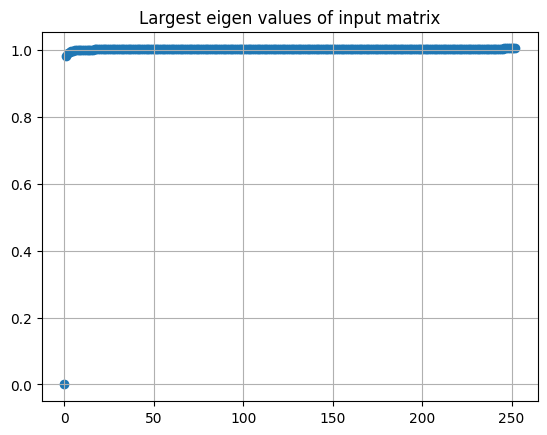

In [39]:
k, _, _ = eigenDecomposition(A)
print(f"Optimal number of clusters: {k}")

In [399]:
from sklearn.cluster import SpectralClustering

In [41]:
# n = 2
clsutering_2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(A)
y_pred_2 = clsutering_2.labels_.astype(int)

In [42]:
buildings_ext_gdf['cluster_2'] = y_pred_2
buildings_ext_gdf['cluster_2'] = buildings_ext_gdf['cluster_2'].astype('category') # Make the column categorical
buildings_ext_gdf

,blockID,geometry,cluster_2
0,1826,"POLYGON ((-9233833.187 4858552.09, -9233833.18...",0
1,1826_1,"POLYGON ((-9233783.814 4858535.969, -9233783.8...",1
2,1869,"POLYGON ((-9233783.642 4859312.213, -9233783.6...",1
3,1882-84,"POLYGON ((-9233632.903 4858483.358, -9233632.9...",1
4,1882-84_1,"POLYGON ((-9233624.734 4858532.58, -9233624.73...",0
...,...,...,...
248,E.L.2060,"POLYGON ((-9233241.372 4858489.717, -9233241.3...",0
249,E.L.2070,"POLYGON ((-9233200.408 4858445.929, -9233200.4...",0
250,R.808,"POLYGON ((-9233787.89 4858808.688, -9233787.89...",1
251,R.808_1,"POLYGON ((-9233756.263 4858789.567, -9233756.2...",1


Text(0.5, 1.0, 'Building Clusters (k=2)')

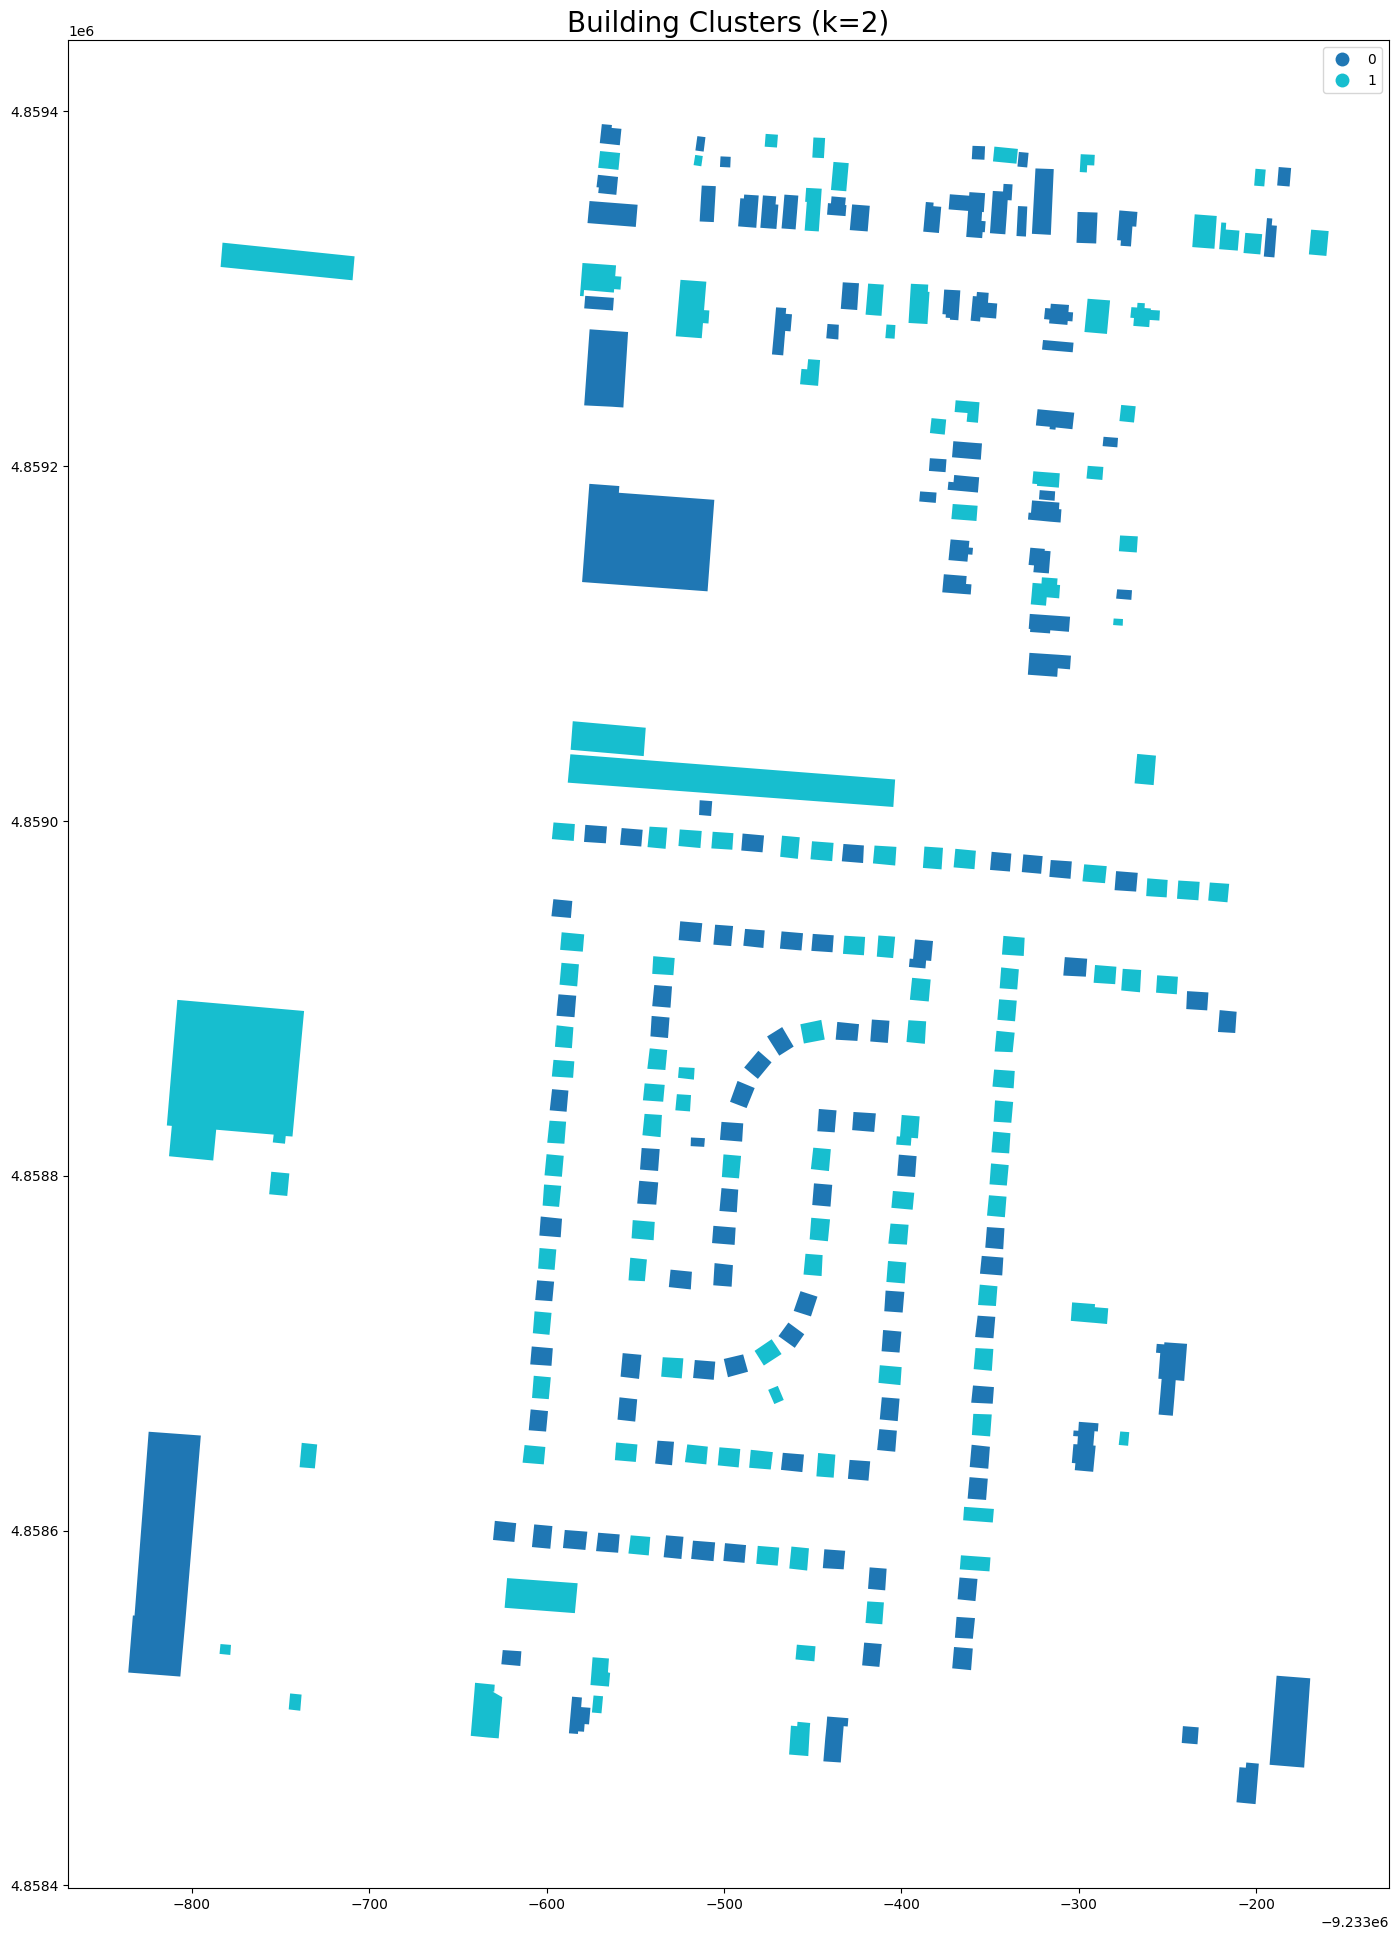

In [43]:
buildings_ext_gdf.plot(column='cluster_2', cmap='tab10', legend=True, figsize=(24,24))
plt.title("Building Clusters (k=2)", fontsize=20)

### **Debugging**

In [116]:
buildings_ext_gdf[buildings_ext_gdf['blockID']=='791']

,blockID,geometry,cluster_2
155,791,"POLYGON ((-9233395.35 4858922.309, -9233395.34...",0


In [117]:
buildings_ext_gdf[buildings_ext_gdf['blockID']=='827_b']

,blockID,geometry,cluster_2
183,827_b,"POLYGON ((-9233394.71 4858817.069, -9233394.71...",1


In [115]:
# 155 and 183 are supposed to be the same, but here shows their pw Wasserstein distance is different
pw_dist.iloc[155,183] 

np.float64(0.21067961165048502)

In [66]:
pw_dist.iloc[221,224] 

np.float64(0.162686567164179)

In [75]:
def pts_to_skeleton_debug(geom):
    '''
    This function extracts points from a geometry, converts them into a polygon, and draws the skeleton of a geometry. It returns a skeleton graph of a geometry
    '''
    points = []
    print(geom.boundary.coords[:-1])
    for x, y in geom.boundary.coords[:-1]:
        points.append(sg.Point2(x,y))
    points_to_poly = points[::-1] # make sure it is counter-clockwise
    poly_to_skel = sg.Polygon(points_to_poly)
    print(len(list(poly_to_skel.vertices)))
    skeleton = sg.skeleton.create_interior_straight_skeleton(poly_to_skel)
    return skeleton

In [81]:
# test case 155 vs 183
ske_155 = pts_to_skeleton_debug(buildings_ext_gdf.geometry[155])
gs_155 = skeleton2networkx(ske_155)
gs_hashes_155 = nx.weisfeiler_lehman_subgraph_hashes(gs_155, iterations=4, digest_size=8)
g_em_155 = graph_embeddings(gs_hashes_155)


ske_183 = pts_to_skeleton_debug(buildings_ext_gdf.geometry[183])
gs_183 = skeleton2networkx(ske_183)
gs_hashes_183 = nx.weisfeiler_lehman_subgraph_hashes(gs_183, iterations=4, digest_size=8)
g_em_183 = graph_embeddings(gs_hashes_183)

gs_155 == gs_183

# m_155_183 = ground_cost_m(g_em_155,g_em_183)
# n_g155, n_g183 = od_vector(g_em_155,g_em_183)
# w_155_183 = ot.emd2(n_g155, n_g183, m_155_183)
# w_155_183

[(-9233395.350327794, 4858922.309338017), (-9233395.347992867, 4858922.3188715), (-9233395.34473458, 4858922.328130157), (-9233395.340584321, 4858922.337024791), (-9233395.335582076, 4858922.345469714), (-9233395.329776036, 4858922.353383566), (-9233395.323222132, 4858922.360690107), (-9233395.31598351, 4858922.367318944), (-9233395.308129901, 4858922.373206219), (-9233395.299736967, 4858922.378295212), (-9233395.290885568, 4858922.3825368965), (-9233395.281660974, 4858922.385890409), (-9233395.272152057, 4858922.388323442), (-9233395.262450423, 4858922.389812555), (-9233395.252649536, 4858922.3903434025), (-9233395.24284382, 4858922.389910871), (-9233393.44924939, 4858922.22230276), (-9233392.384140367, 4858933.10155284), (-9233392.38271828, 4858933.11119938), (-9233392.380363459, 4858933.12066156), (-9233392.37709829, 4858933.129849418), (-9233392.372953821, 4858933.138675596), (-9233392.367969453, 4858933.147056177), (-9233392.36219258, 4858933.15491148), (-9233392.355678126, 485893

False

In [82]:
buildings_ext_gdf.iloc[155]

blockID                                                    791
geometry     POLYGON ((-9233395.350327794 4858922.309338017...
cluster_2                                                    0
Name: 155, dtype: object

In [109]:
print(f"number of vertices in blockID 791: {len(list(ske_155.vertices))}")
print(f"number of vertices in blockID 827b: {len(list(ske_183.vertices))}")

number of vertices in blockID 791: 206
number of vertices in blockID 827b: 206


In [110]:
buildings_ext_raw[buildings_ext_raw['blockID'] == '791']

,stories,materials,blockID,height(m),geometry
190,1.5,frame or wood,791,NaN,"POLYGON ((-9233386.176 4858921.442, -9233386.1..."
191,1,frame or wood,791,NaN,"POLYGON ((-9233395.252 4858922.29, -9233386.17..."


In [111]:
len(list(buildings_ext_raw.geometry[190].exterior.coords))

7

In [112]:
len(list(buildings_ext_raw_boundary.geometry[190].exterior.coords))

70

In [113]:
len(list(buildings_ext_raw.geometry[191].exterior.coords))

5

In [114]:
len(list(buildings_ext_raw_boundary.geometry[191].exterior.coords))

69

## **Problems identified**

1. The polygon itself has many overlapping vertices, as shown in `buildings_ext_raw` (before dissolve) and `buildings_ext_raw_boundary` (after dissolve to get the exterior boundary) for `blockID==791`, it should only have 8 vertices, but now they 12 vertices (before dissolve) and 139 (after dissolve).
2. This leads to the problem where in the skeleton built, the same building has 206 vertices.
3. That is why though blockID 791 and 827_b have the same polygonal shape or visibly medial axis shape, their pairwise Wasserstein distance is not 0 since they have different numbers of overlapping nodes and vertices.

In [417]:
# simplified shp in QGIS using the simplify tool
# load simplified shp
buildings_ext_raw_sim = gpd.read_file("./data/input/529E_ext_bound_simplified/529E_ext_bound_simplified.shp")
buildings_ext_raw_sim

,stories,materials,blockID,height(m),geometry
0,2,frame or wood,630,NaN,"POLYGON ((-9233563.682 4859388.217, -9233563.4..."
1,2,concrete and cinder block,1974_1,NaN,"POLYGON ((-9233450.127 4859373.974, -9233449.5..."
2,1,frame or wood,2010_1,NaN,"POLYGON ((-9233348.309 4859371.8, -9233347.519..."
3,2,frame or wood,636,NaN,"POLYGON ((-9233558.67 4859376.354, -9233559.59..."
4,1,frame or wood,1956_kento,NaN,"POLYGON ((-9233502.187 4859368.688, -9233501.8..."
...,...,...,...,...,...
332,None,brick or tile,R.808,3.6576,"POLYGON ((-9233811.121 4858828.158, -9233786.3..."
333,None,None,1826,10.0584,"POLYGON ((-9233824.192 4858655.628, -9233794.9..."
334,None,None,1826,15.2400,"POLYGON ((-9233833.089 4858552.073, -9233803.6..."
335,1,brick or tile,1826_1,NaN,"POLYGON ((-9233783.715 4858535.96, -9233777.99..."


In [159]:
# identify the same building with blockID 791, the bigger 1.5 stories polygon
buildings_ext_raw_sim[buildings_ext_raw_sim['blockID'] == '791']

,stories,materials,blockID,height(m),geometry
190,1.5,frame or wood,791,NaN,"POLYGON ((-9233383.335 4858921.171, -9233393.3..."
191,1,frame or wood,791,NaN,"POLYGON ((-9233395.252 4858922.29, -9233386.17..."


In [160]:
# check number of vertices, the bigger 1.5 stories polygon
len(list(buildings_ext_raw_sim.geometry[190].exterior.coords[:-1]))

4

In [161]:
list(buildings_ext_raw_sim.geometry[190].exterior.coords[:-1])

[(-9233383.335317984, 4858921.17113294),
 (-9233393.35932318, 4858922.114523474),
 (-9233392.284616197, 4858933.091809145),
 (-9233382.306650875, 4858932.216082298)]

In [162]:
# check number of vertices, the smaller 1 story polygon
len(list(buildings_ext_raw_sim.geometry[191].exterior.coords[:-1]))

4

In [163]:
# identify the same building with blockID 279, a 1.5 stories CapeCod
buildings_ext_raw_sim[buildings_ext_raw_sim['blockID'] == '879']

,stories,materials,blockID,height(m),geometry
182,1.5,frame or wood,879,NaN,"POLYGON ((-9233612.332 4858648.117, -9233600.8..."


In [164]:
# check number of vertices
len(list(buildings_ext_raw_sim.geometry[182].exterior.coords))

5

***Attempt 2***
## PART I: Skeleton Graph Computation
### **Step 1: Medial Axis Approximation (Approach 4 Point reduction and edge construction in step 1, scikit geometry in step 2)**
### ***Ext. Boundaries***

**1.1 Load data and plot edges and points**

In [ ]:
# from shapely import geos
# print(geos.geos_version)

In [101]:
# buildings_ext_boundary_diss.loc['827_b']
# print(f"number of vertices in blockID 827_b: {len(list(buildings_ext_boundary_diss.geometry['827_b'].exterior.coords[:-1]))}")

geometry    POLYGON ((-9233394.71 4858817.069, -9233394.71...
Name: 827_b, dtype: geometry

In [165]:
# dissolve multipart polygons
smi_buildings_ext_raw_boundary = buildings_ext_raw_sim[["blockID", "stories", "materials", "geometry"]]
smi_buildings_ext_raw_boundary.loc[:,"geometry"] = smi_buildings_ext_raw_boundary["geometry"].buffer(0.1)
sim_buildings_ext_boundary_diss = smi_buildings_ext_raw_boundary.dissolve(by="blockID")

# extra vertices were created during the dissolve process, simplify them
sim_buildings_ext_boundary_diss.loc[:,"geometry"] = sim_buildings_ext_boundary_diss["geometry"].simplify(tolerance=0.3, preserve_topology=False)

sim_buildings_ext_boundary_diss

,geometry,stories,materials
blockID,,,
1826,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",None,None
1826_1,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",1,brick or tile
1869,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",None,concrete and cinder block
1882-84,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",1,frame or wood
1882-84_1,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",1,frame or wood
...,...,...,...
E.L.2060,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",1,frame or wood
E.L.2070,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",1,frame or wood
R.808,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",None,brick or tile


In [166]:
# identify the same building with blockID 791, the bigger 1.5 stories polygon
print(sim_buildings_ext_boundary_diss.loc['1826'])
#print(sim_buildings_ext_boundary_diss.loc['2007_kento'])

print(len(list(sim_buildings_ext_boundary_diss.geometry['1826'].exterior.coords[:-1])))
#print(len(list(sim_buildings_ext_boundary_diss.geometry['2007_kento'].exterior.coords[:-1])))

geometry     POLYGON ((-9233833.187331954 4858552.090373429...
stories                                                   None
materials                                                 None
Name: 1826, dtype: object
6


There are still polygons with extra vertices. Below shows the `blockID` of polygons with extra vertices that can't be simplified with the `simplify()` method with `tolerance=0.1`:

- 640
- 1954
- 1972
- 708
- 1825
- 1882-84
- 2004

Only `tolerance=0.1` can fix most of the polygons, except for 1882-84, which has a weird polygon shape anyway.

In [167]:
sim_buildings_ext_boundary_diss.explore()

In [168]:
#sim_buildings_ext_boundary_diss.to_file("./data/output/sim_buildings_ext_boundary_diss.shp", driver="ESRI Shapefile")

**Load repaired gdf data**

In [169]:
# load building footprint for cleaning - ext boundaries
sim_buildings_ext_gdf, sim_points_ext_gdf, sim_edges_ext_gdf = sample_points_at_vertices("./data/output/sim_buildings_ext_boundary_diss.shp")

In [290]:
## data check
#sim_buildings_ext_gdf
#sim_buildings_ext_gdf[sim_buildings_ext_gdf['blockID']== 'C']
#len(list(sim_buildings_ext_gdf.geometry[242].exterior.coords[:-1]))

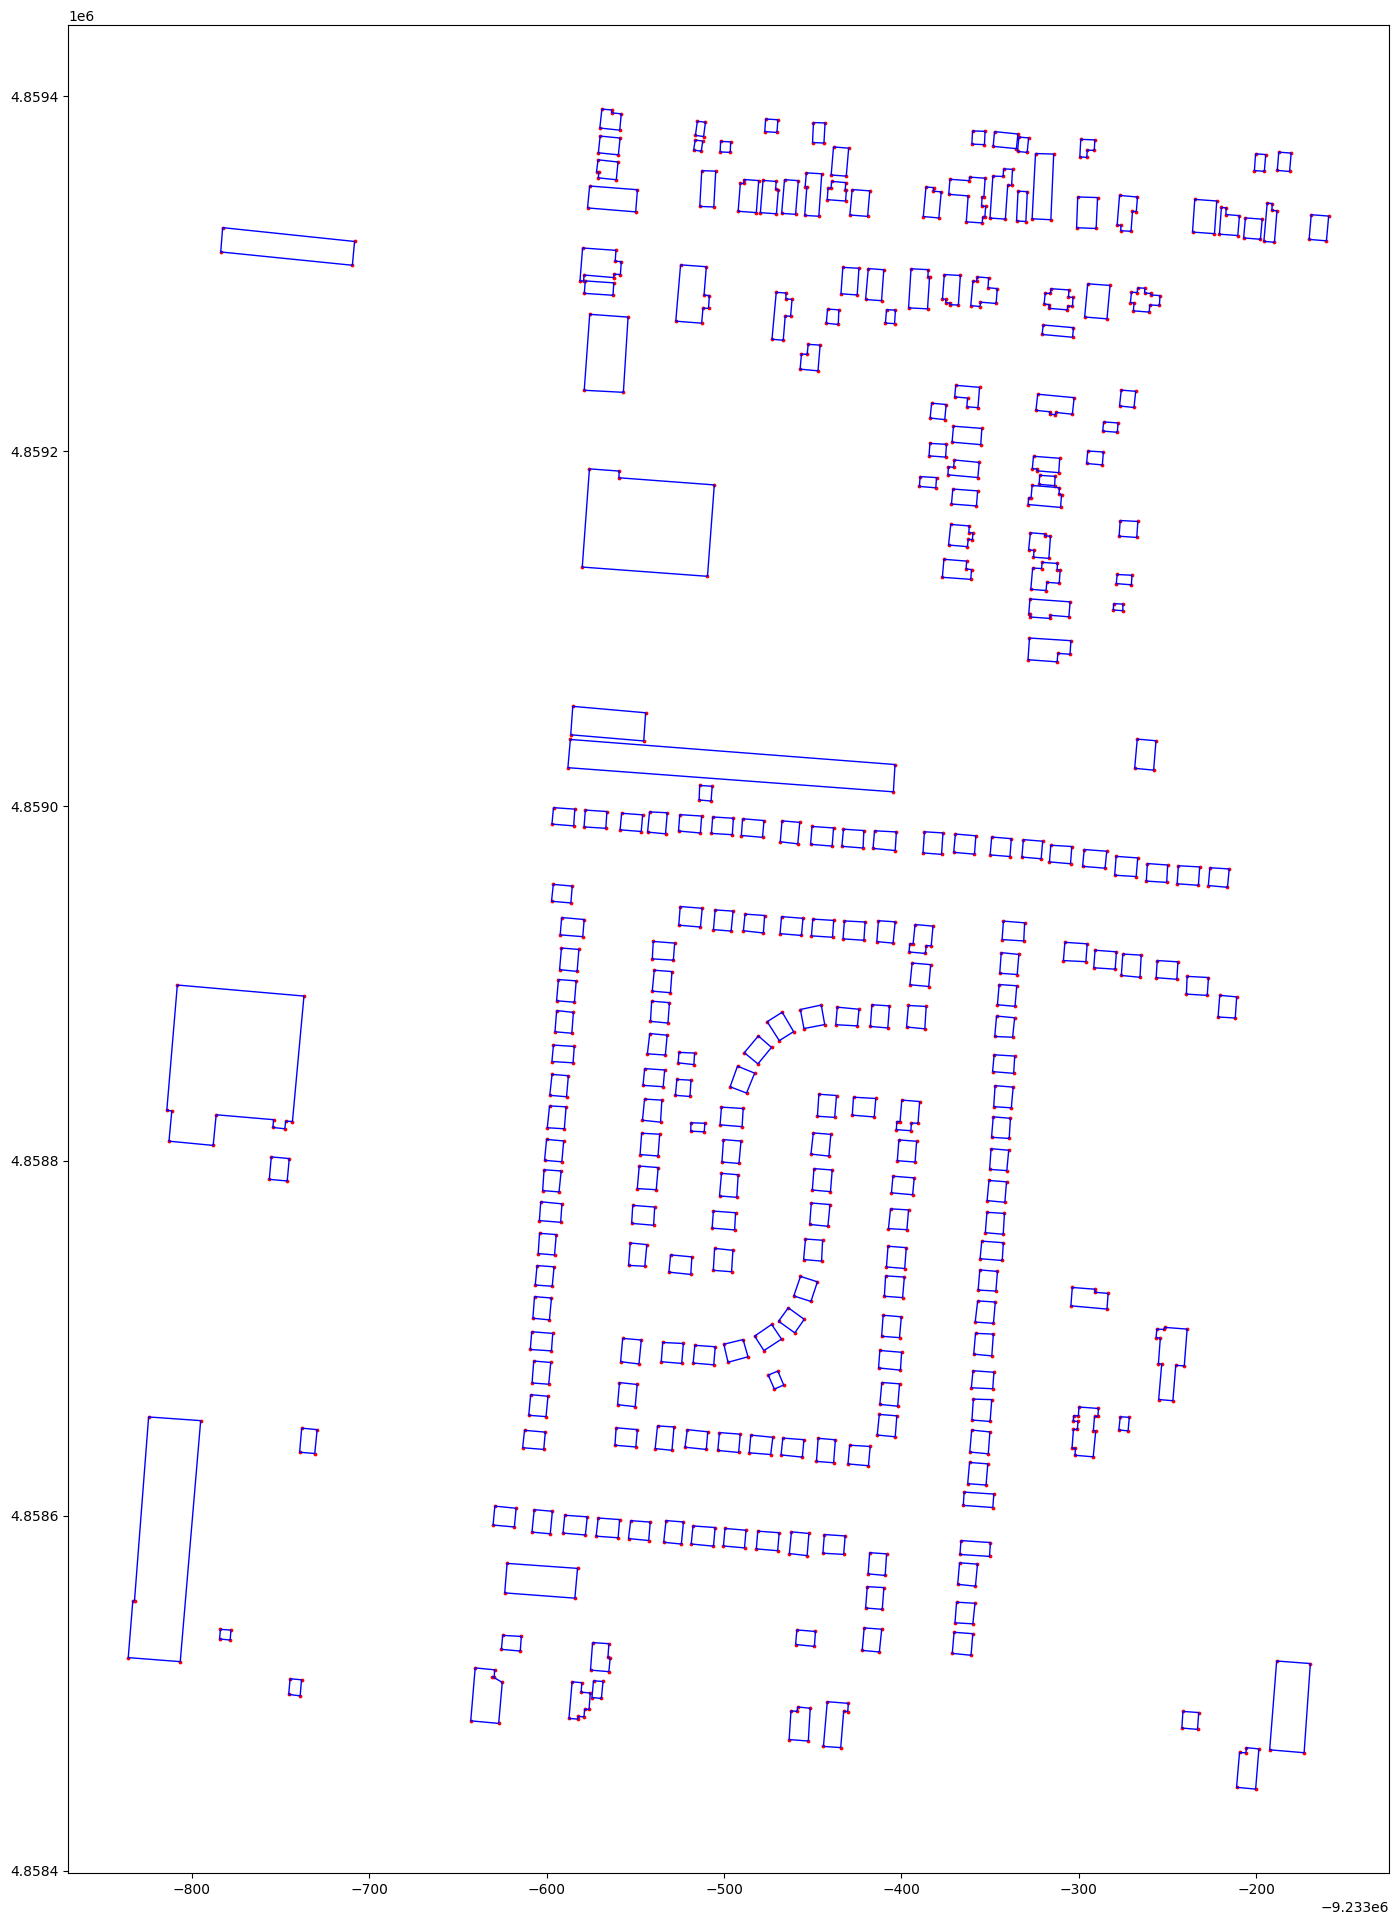

In [291]:
# plot
fig, ax = plt.subplots(figsize=(24, 24))
sim_edges_ext_gdf.plot(ax=ax, edgecolor='blue', linewidth=1, facecolor='none')
sim_points_ext_gdf.plot(ax=ax, color='red', markersize=3)
#plt.savefig("./data/output/for_ext_bound_vetices_edges_reduced_points.png", dpi=1200, bbox_inches='tight')
plt.show()

**1.2 Medial axis construction**

In [378]:
all_poly = []
all_skeleton = []

for idx, row in sim_buildings_ext_gdf.iterrows():
    geom = row.geometry
    #print(geom)

    # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
    if geom is None or not isinstance(geom, (Polygon, MultiPolygon)): 
        print(idx)
        print(geom)
        continue

    # continue to work with geom that is not null
    # for each geom, extract the points and convert them to sg.Point2; use the points to create and draw poly; create the skeleton for each geom
    points = []
    for x,y in geom.boundary.coords[:-1]: # [:-1] to exclude the last point that is used to close the polygon
        points.append(sg.Point2(x,y))
         
    poly = sg.Polygon(points[::-1]) # reverse order of the points    
    all_poly.append(poly)
    skel = sg.skeleton.create_interior_straight_skeleton(poly)        
    all_skeleton.append(skel)

#print(idx)
#print(all_poly)
#len(all_poly)

In [379]:
for idx, x in enumerate(all_skeleton):
    if x == None:
        print(idx, x)

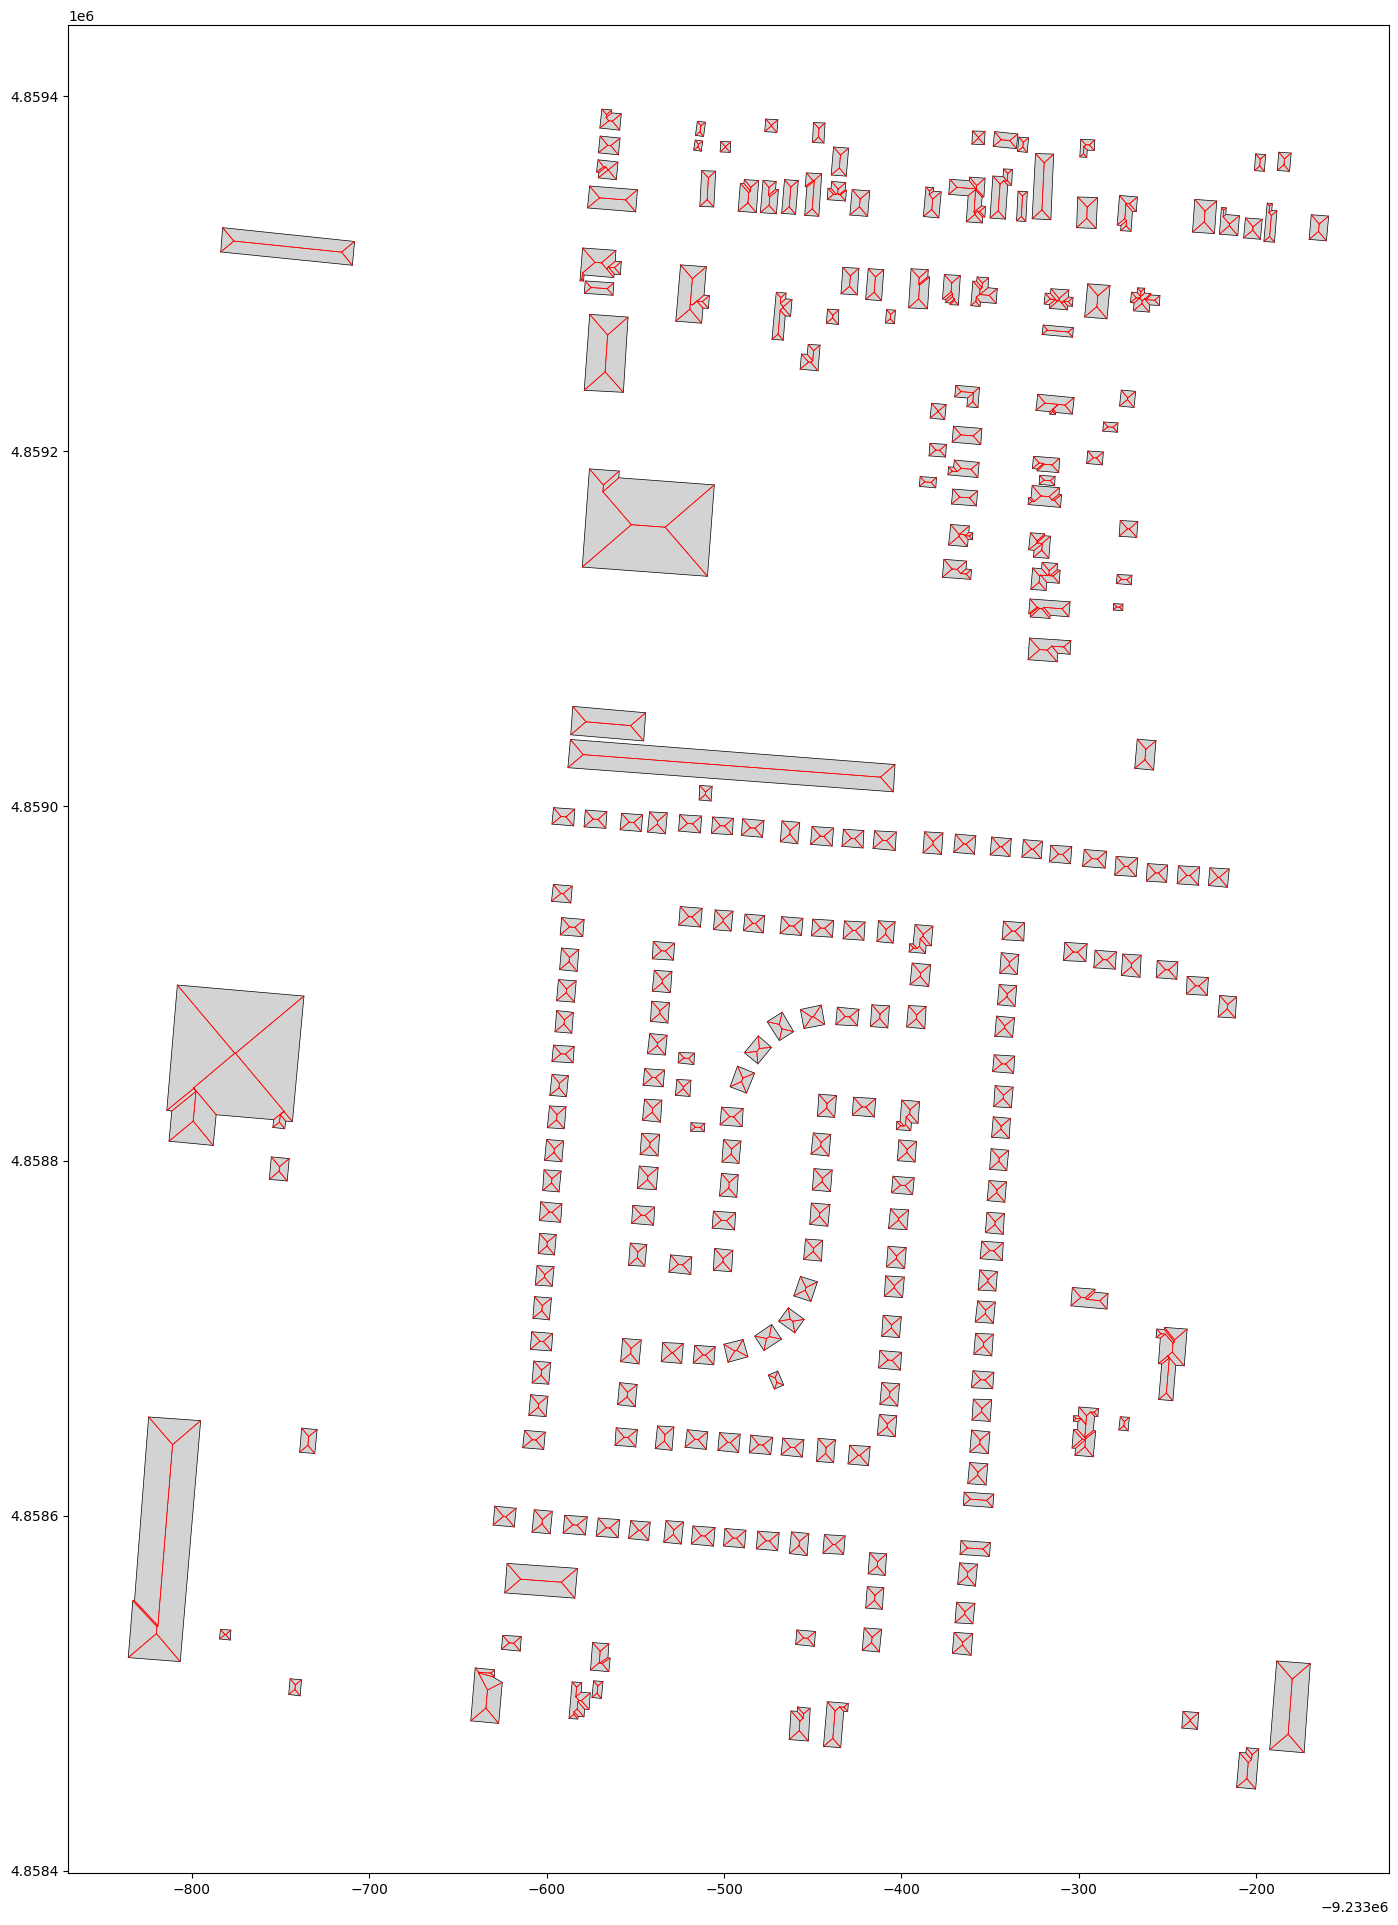

In [380]:
draw_all_skeletons(all_poly,all_skeleton)
plt.savefig("./data/output/repaired_ext_bound_scikit_geom.png", dpi=1200, bbox_inches='tight')

**Data checking by looking at `blockID=791` and `blockID=827_b`.**

In [375]:
# test case 155 vs 183
repaired_ske_155 = pts_to_skeleton_debug(sim_buildings_ext_gdf.geometry[155])
repaired_gs_155 = skeleton2networkx(repaired_ske_155)
repaired_gs_hashes_155 = nx.weisfeiler_lehman_subgraph_hashes(repaired_gs_155, iterations=4)
repaired_g_em_155 = graph_embeddings(repaired_gs_hashes_155)


repaired_ske_183 = pts_to_skeleton_debug(sim_buildings_ext_gdf.geometry[183])
repaired_gs_183 = skeleton2networkx(repaired_ske_183)
repaired_gs_hashes_183 = nx.weisfeiler_lehman_subgraph_hashes(repaired_gs_183, iterations=4)
repaired_g_em_183 = graph_embeddings(repaired_gs_hashes_183)

repaired_g_em_155 == repaired_g_em_183

repaired_m_155_183 = ground_cost_m(repaired_g_em_155,repaired_g_em_183)
r_n_g155, r_n_g183 = od_vector(repaired_g_em_155,repaired_g_em_183)
r_w_155_183 = ot.emd2(r_n_g155, r_n_g183, repaired_m_155_183)
r_w_155_183

[(-9233395.350327794, 4858922.309338017), (-9233393.44924939, 4858922.22230276), (-9233392.34848803, 4858933.1687532095), (-9233382.229857925, 4858932.280135735), (-9233383.239474675, 4858921.142601206), (-9233386.085206416, 4858921.329491668), (-9233386.502414847, 4858916.881869045), (-9233395.72690159, 4858917.701397492)]
8
[(-9233402.60527609, 4858822.140553164), (-9233400.808518142, 4858822.08848019), (-9233399.82294558, 4858834.237374693), (-9233389.758077284, 4858833.436819507), (-9233390.696459858, 4858821.165435797), (-9233394.379572349, 4858821.377593416), (-9233394.74490846, 4858817.000676503), (-9233402.912767954, 4858817.569913547)]
8


0.0

In [349]:
len(list(sim_buildings_ext_gdf.geometry[155].exterior.coords[:-1]))

8

In [350]:
sim_buildings_ext_gdf.iloc[155]
sim_buildings_ext_gdf.iloc[183]

blockID                                                  827_b
stories                                                    1.5
materials                                        frame or wood
geometry     POLYGON ((-9233402.60527609 4858822.140553164,...
Name: 183, dtype: object

In [351]:
print(f"number of vertices in blockID 791: {len(list(repaired_ske_155.vertices))}")
print(f"number of vertices in blockID 827b: {len(list(repaired_ske_183.vertices))}")

number of vertices in blockID 791: 14
number of vertices in blockID 827b: 14


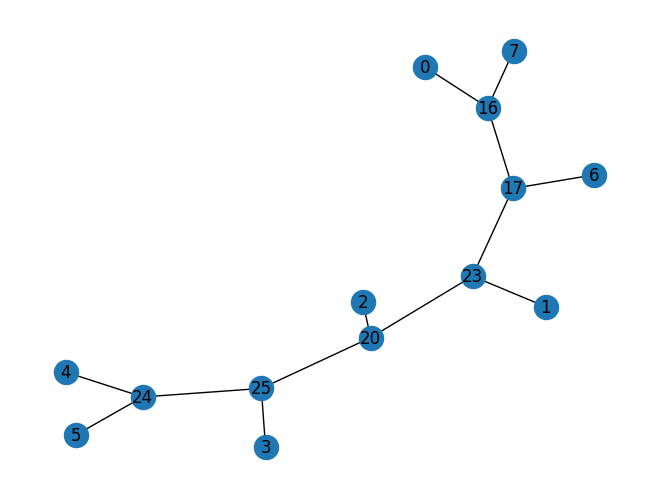

In [352]:
nx.draw(repaired_gs_155, with_labels=True)

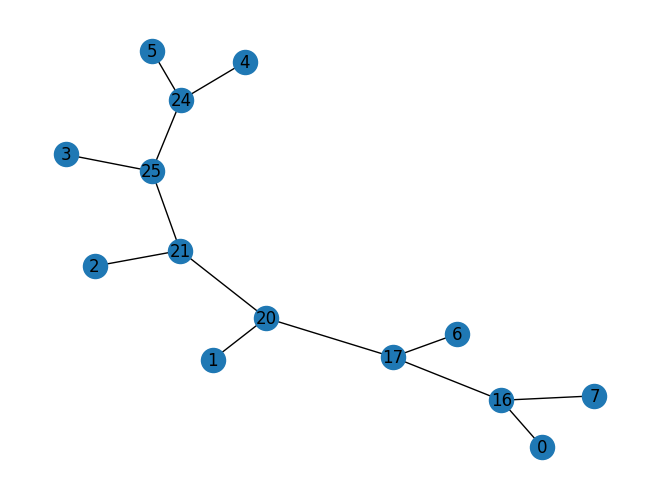

In [353]:
nx.draw(repaired_gs_183, with_labels=True)

**Data checking by looking at `blockID=221` and `blockID=224`.**

In [376]:
# test case 155 vs 183
repaired_ske_221 = pts_to_skeleton_debug(sim_buildings_ext_gdf.geometry[221])
repaired_gs_221 = skeleton2networkx(repaired_ske_221)
repaired_gs_hashes_221 = nx.weisfeiler_lehman_subgraph_hashes(repaired_gs_221, iterations=4)
repaired_g_em_221 = graph_embeddings(repaired_gs_hashes_221)


repaired_ske_224 = pts_to_skeleton_debug(sim_buildings_ext_gdf.geometry[224])
repaired_gs_224 = skeleton2networkx(repaired_ske_224)
repaired_gs_hashes_224 = nx.weisfeiler_lehman_subgraph_hashes(repaired_gs_224, iterations=4)
repaired_g_em_224 = graph_embeddings(repaired_gs_hashes_224)

repaired_g_em_221 == repaired_g_em_224

repaired_m_221_224 = ground_cost_m(repaired_g_em_221,repaired_g_em_224)
r_n_g221, r_n_g224 = od_vector(repaired_g_em_221,repaired_g_em_224)
r_w_221_224 = ot.emd2(r_n_g221, r_n_g224, repaired_m_221_224)
r_w_221_224

[(-9233608.992259398, 4858668.227347319), (-9233599.224052496, 4858667.315247557), (-9233600.32172525, 4858655.843670114), (-9233610.046444068, 4858656.6024284065)]
4
[(-9233612.431582486, 4858648.127840477), (-9233600.731077887, 4858647.11644061), (-9233601.603788216, 4858637.361626107), (-9233613.50222351, 4858638.319135998)]
4


0.0

In [377]:
repaired_m_155_224 = ground_cost_m(repaired_g_em_155,repaired_g_em_224)
r_n_g155, r_n_g224 = od_vector(repaired_g_em_155,repaired_g_em_224)
r_w_155_224 = ot.emd2(r_n_g155, r_n_g224, repaired_m_155_224)
r_w_155_224

0.6

## PART II: Clustering

**2.1 Graph Embedding and Weisfeiler-Lehman Label Propagation** </br>
**2.2 Graph Wasserstein Distance using Optimal Transport Theory**

In [381]:
reparied_HV_529E_ext_bound_dist_m = bldgFootprint_pairwiseWassersteinDistance(sim_buildings_ext_gdf)
print(reparied_HV_529E_ext_bound_dist_m)

[[0.         0.56       0.56       ... 0.41090909 0.56       0.56      ]
 [0.56       0.         0.         ... 0.63636364 0.         0.        ]
 [0.56       0.         0.         ... 0.63636364 0.         0.        ]
 ...
 [0.41090909 0.63636364 0.63636364 ... 0.         0.63636364 0.63636364]
 [0.56       0.         0.         ... 0.63636364 0.         0.        ]
 [0.56       0.         0.         ... 0.63636364 0.         0.        ]]


In [386]:
# convert numpy array to a python list
reparied_HV_529E_ext_bound_dist_m_list = reparied_HV_529E_ext_bound_dist_m.tolist()

# define path to the json file
repaired_json_file_path = "./data/output/repaired_HV_529E_ext_bound_pw_dist.json"

# write the Python list to a json file
with open(repaired_json_file_path, 'w') as json_file:
    json.dump(reparied_HV_529E_ext_bound_dist_m_list, json_file)

**2.3 Spectral Clustering**

In [388]:
# load the json file
repaired_pw_dist = pd.read_json("./data/output/repaired_HV_529E_ext_bound_pw_dist.json")
repaired_pw_dist

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,0.000000,0.560000,0.560000,0.236667,0.560000,0.386667,0.000000,0.560000,0.560000,0.560000,...,0.560000,0.560000,0.000000,0.000000,0.560000,0.560000,0.000000,0.410909,0.560000,0.560000
1,0.560000,0.000000,0.000000,0.583333,0.000000,0.588889,0.560000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.560000,0.560000,0.000000,0.000000,0.560000,0.636364,0.000000,0.000000
2,0.560000,0.000000,0.000000,0.583333,0.000000,0.588889,0.560000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.560000,0.560000,0.000000,0.000000,0.560000,0.636364,0.000000,0.000000
3,0.236667,0.583333,0.583333,0.000000,0.583333,0.322222,0.236667,0.583333,0.583333,0.583333,...,0.583333,0.583333,0.236667,0.236667,0.583333,0.583333,0.236667,0.303030,0.583333,0.583333
4,0.560000,0.000000,0.000000,0.583333,0.000000,0.588889,0.560000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.560000,0.560000,0.000000,0.000000,0.560000,0.636364,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.560000,0.000000,0.000000,0.583333,0.000000,0.588889,0.560000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.560000,0.560000,0.000000,0.000000,0.560000,0.636364,0.000000,0.000000
249,0.000000,0.560000,0.560000,0.236667,0.560000,0.386667,0.000000,0.560000,0.560000,0.560000,...,0.560000,0.560000,0.000000,0.000000,0.560000,0.560000,0.000000,0.410909,0.560000,0.560000
250,0.410909,0.636364,0.636364,0.303030,0.636364,0.381818,0.410909,0.636364,0.636364,0.636364,...,0.636364,0.636364,0.410909,0.410909,0.636364,0.636364,0.410909,0.000000,0.636364,0.636364
251,0.560000,0.000000,0.000000,0.583333,0.000000,0.588889,0.560000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.560000,0.560000,0.000000,0.000000,0.560000,0.636364,0.000000,0.000000


In [389]:
# convert df to nparray
rpaired_pw_dist_np = repaired_pw_dist.to_numpy()
rpaired_pw_dist_np

array([[0.        , 0.56      , 0.56      , ..., 0.41090909, 0.56      ,
        0.56      ],
       [0.56      , 0.        , 0.        , ..., 0.63636364, 0.        ,
        0.        ],
       [0.56      , 0.        , 0.        , ..., 0.63636364, 0.        ,
        0.        ],
       ...,
       [0.41090909, 0.63636364, 0.63636364, ..., 0.        , 0.63636364,
        0.63636364],
       [0.56      , 0.        , 0.        , ..., 0.63636364, 0.        ,
        0.        ],
       [0.56      , 0.        , 0.        , ..., 0.63636364, 0.        ,
        0.        ]], shape=(253, 253))

In [391]:
# 155 and 183 are supposed to be the same
repaired_pw_dist.iloc[155,183] 

np.float64(0.0)

In [392]:
# 221 and 224 are supposed to be the same
repaired_pw_dist.iloc[221,224] 

np.float64(0.0)

In [393]:
# 155 and 224 are not supposed to be the same
repaired_pw_dist.iloc[155,224] 

np.float64(0.6000000000000001)

**(Simple) Adjacency Matrix**

In [394]:
# construct adjacency matrix from the distance matrix
# based on the lecture video, in A matrix, it should be 0 in the diagonal
# 1 - HV_529E_dist_m will create a diagonal with the value of 1, np.eye() is to subtract the diagonal by 1 to get 0
repaired_A = 1-rpaired_pw_dist_np - np.eye(rpaired_pw_dist_np.shape[0])
repaired_A

array([[0.        , 0.44      , 0.44      , ..., 0.58909091, 0.44      ,
        0.44      ],
       [0.44      , 0.        , 1.        , ..., 0.36363636, 1.        ,
        1.        ],
       [0.44      , 1.        , 0.        , ..., 0.36363636, 1.        ,
        1.        ],
       ...,
       [0.58909091, 0.36363636, 0.36363636, ..., 0.        , 0.36363636,
        0.36363636],
       [0.44      , 1.        , 1.        , ..., 0.36363636, 0.        ,
        1.        ],
       [0.44      , 1.        , 1.        , ..., 0.36363636, 1.        ,
        0.        ]], shape=(253, 253))

In [395]:
# construct laplacian matrix, L = D - A
# compute D
repaired_D = np.diag(repaired_A.sum(axis=1))
print(repaired_D)

[[128.2123421    0.           0.         ...   0.           0.
    0.        ]
 [  0.         224.80847042   0.         ...   0.           0.
    0.        ]
 [  0.           0.         224.80847042 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 104.34141414   0.
    0.        ]
 [  0.           0.           0.         ...   0.         224.80847042
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  224.80847042]]


**Laplacian Matrix**

In [396]:
# compute L
repaired_L = repaired_D - repaired_A
print(repaired_L)

[[128.2123421   -0.44        -0.44       ...  -0.58909091  -0.44
   -0.44      ]
 [ -0.44       224.80847042  -1.         ...  -0.36363636  -1.
   -1.        ]
 [ -0.44        -1.         224.80847042 ...  -0.36363636  -1.
   -1.        ]
 ...
 [ -0.58909091  -0.36363636  -0.36363636 ... 104.34141414  -0.36363636
   -0.36363636]
 [ -0.44        -1.          -1.         ...  -0.36363636 224.80847042
   -1.        ]
 [ -0.44        -1.          -1.         ...  -0.36363636  -1.
  224.80847042]]


**K-mean Clustering**

- ***Eigengap heuristic for finding the optimal number of clusters***

/tmp/ipykernel_71925/1593121976.py:27: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)


Optimal number of clusters: [1 2 3 4 5]


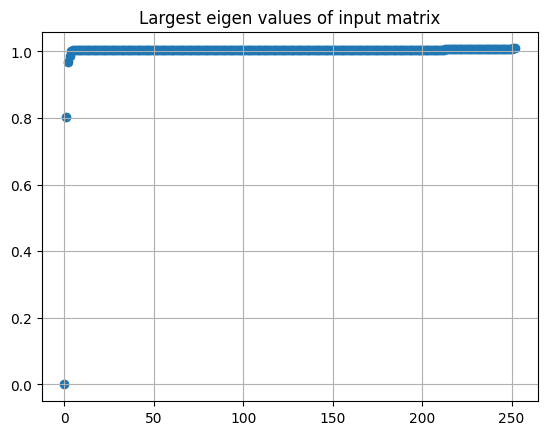

In [400]:
r_k, _, _ = eigenDecomposition(repaired_A)
print(f"Optimal number of clusters: {r_k}")

- **n = 2**

In [404]:
# n = 2
r_clsutering_2 = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(repaired_A)
r_y_pred_2 = r_clsutering_2.labels_.astype(int)

In [402]:
sim_buildings_ext_gdf['cluster_2'] = r_y_pred_2
sim_buildings_ext_gdf['cluster_2'] = sim_buildings_ext_gdf['cluster_2'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",1
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0
...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",1
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0


Text(0.5, 1.0, '(repaired) Building Clusters (k=2)')

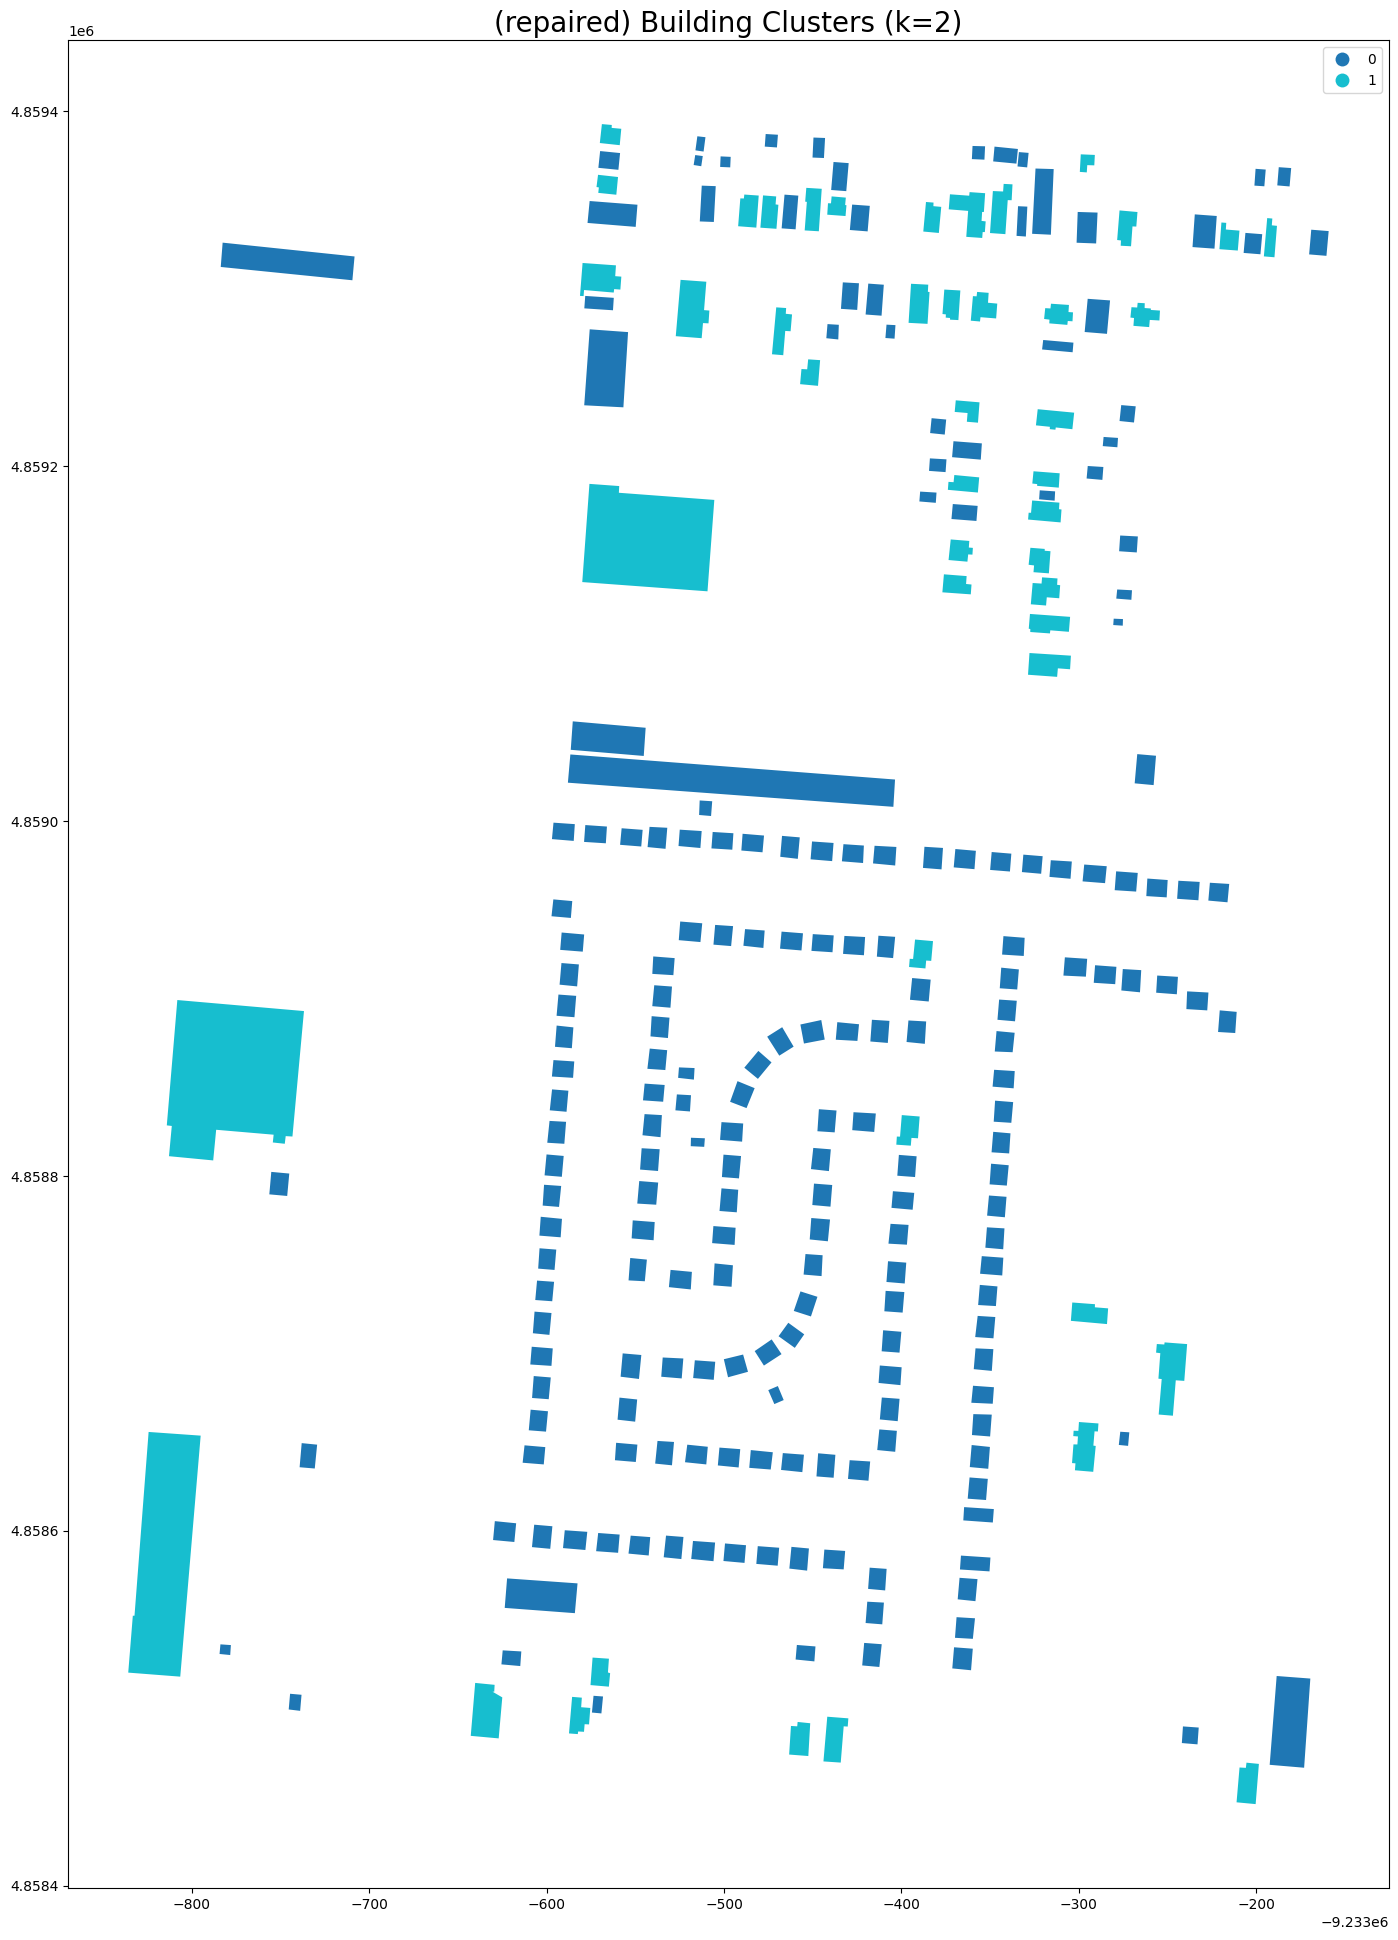

In [403]:
sim_buildings_ext_gdf.plot(column='cluster_2', cmap='tab10', legend=True, figsize=(24,24))
plt.title("(repaired) Building Clusters (k=2)", fontsize=20)

- **n = 3**

In [405]:
r_clsutering_3 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(repaired_A)
r_y_pred_3 = r_clsutering_3.labels_.astype(int)

In [406]:
sim_buildings_ext_gdf['cluster_3'] = r_y_pred_3
sim_buildings_ext_gdf['cluster_3'] = sim_buildings_ext_gdf['cluster_3'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2,cluster_3
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,2
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0,0
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0,0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",1,1
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0,0
...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",1,2
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0,0


Text(0.5, 1.0, '(repaired) Building Clusters (k=3)')

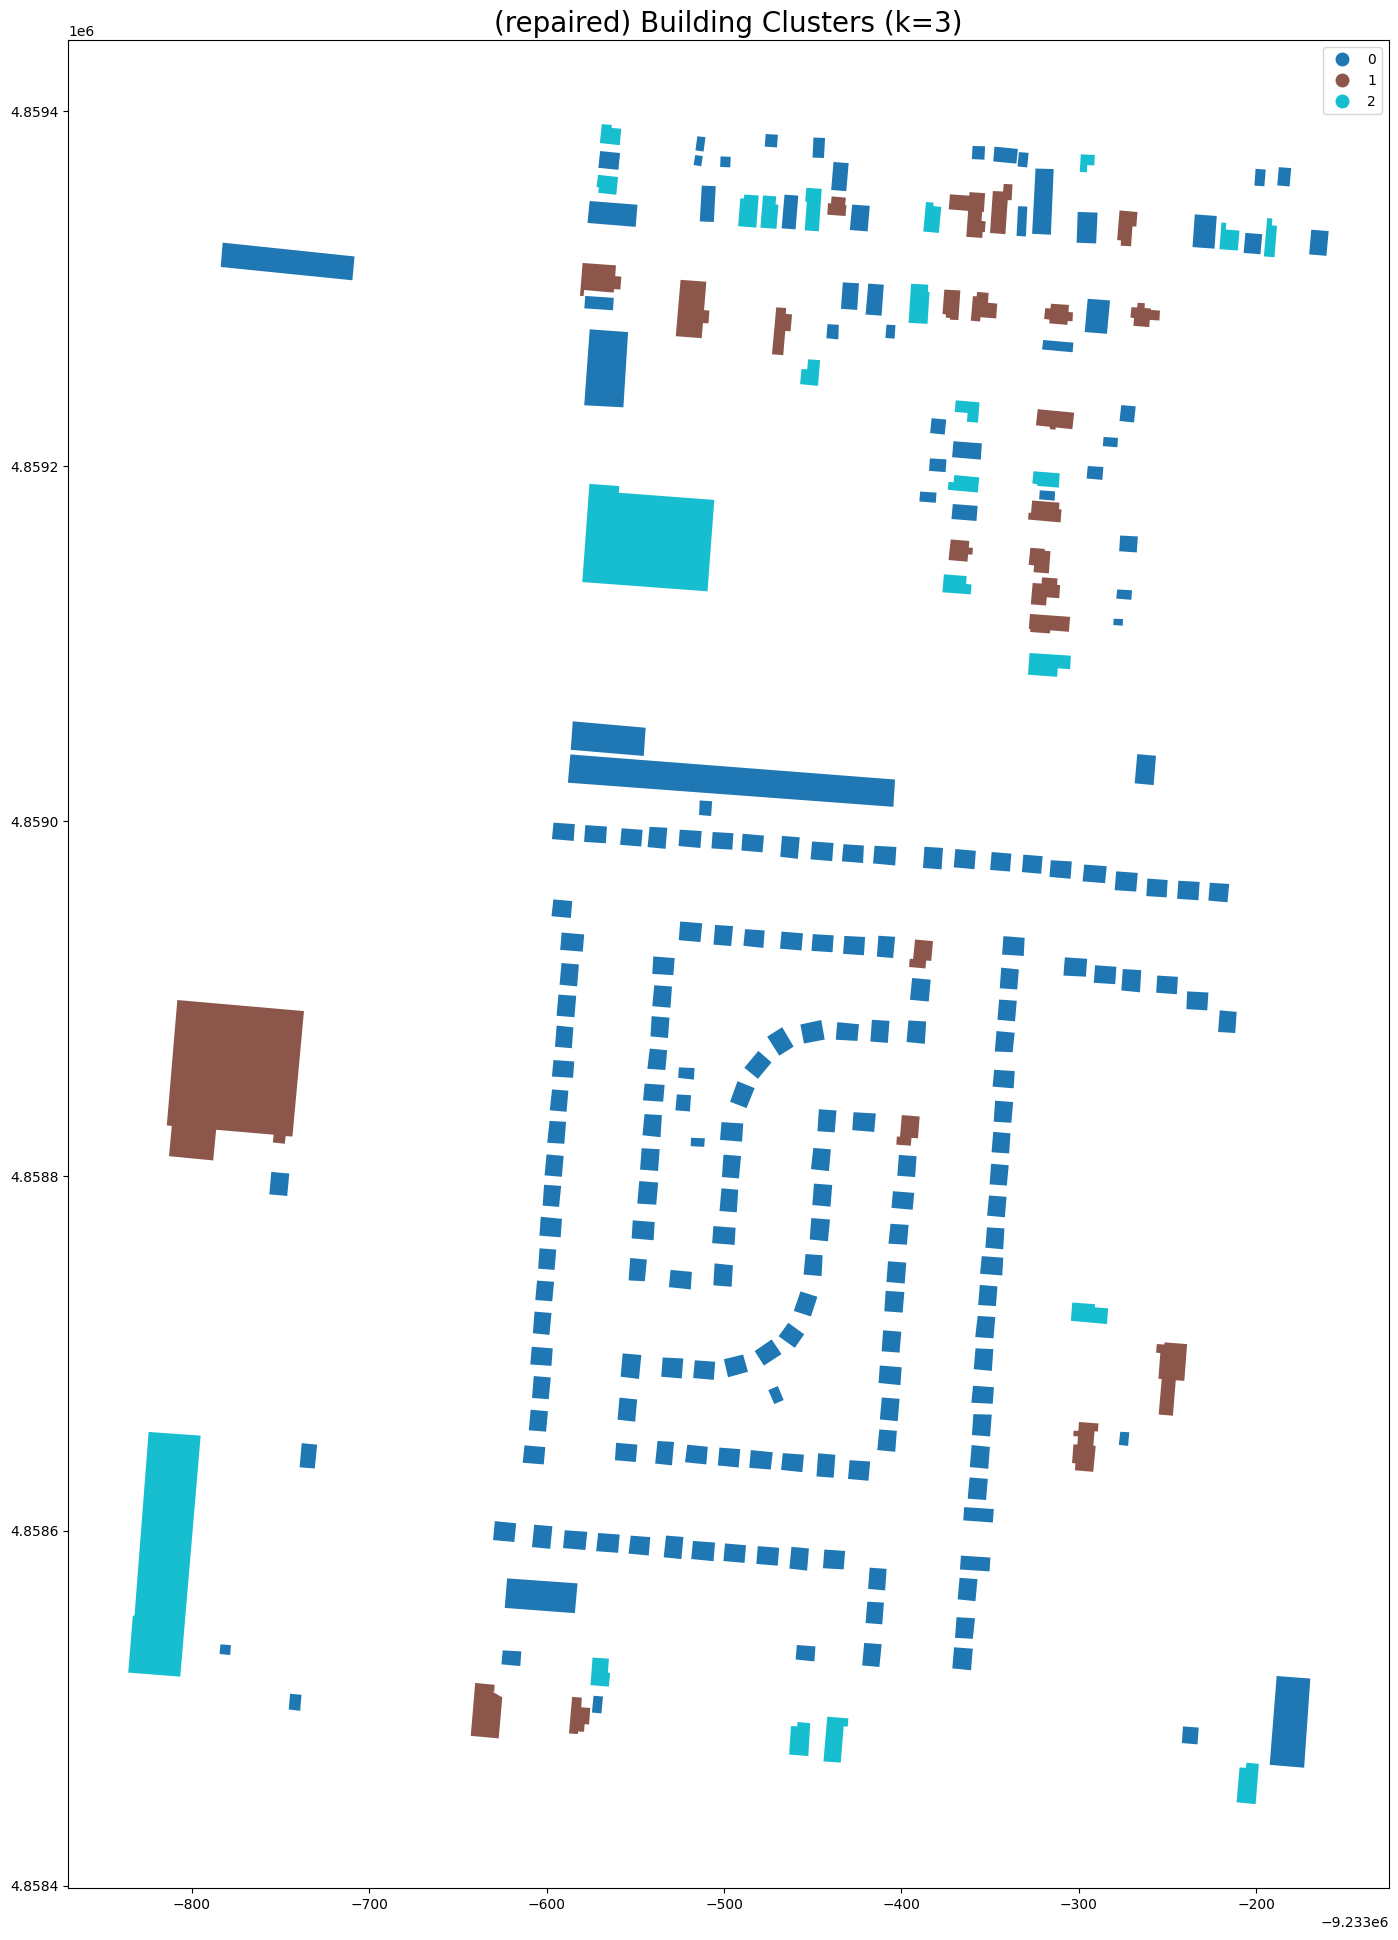

In [407]:
sim_buildings_ext_gdf.plot(column='cluster_3', cmap='tab10', legend=True, figsize=(24,24))
plt.title("(repaired) Building Clusters (k=3)", fontsize=20)

- **n = 4**

In [408]:
r_clsutering_4 = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans', random_state=0).fit(repaired_A)
r_y_pred_4 = r_clsutering_4.labels_.astype(int)

In [409]:
sim_buildings_ext_gdf['cluster_4'] = r_y_pred_4
sim_buildings_ext_gdf['cluster_4'] = sim_buildings_ext_gdf['cluster_4'].astype('category') # Make the column categorical
sim_buildings_ext_gdf

,blockID,stories,materials,geometry,cluster_2,cluster_3,cluster_4
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24...",1,2,2
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9...",0,0,0
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5...",0,0,0
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2...",1,1,1
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24...",0,0,0
...,...,...,...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4...",0,0,0
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1...",1,2,2
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80...",1,1,1
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1...",0,0,0


/tmp/ipykernel_71925/943281189.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = cm.get_cmap('tab10')


Text(0.5, 1.0, '(repaired) Building Clusters (k=4)')

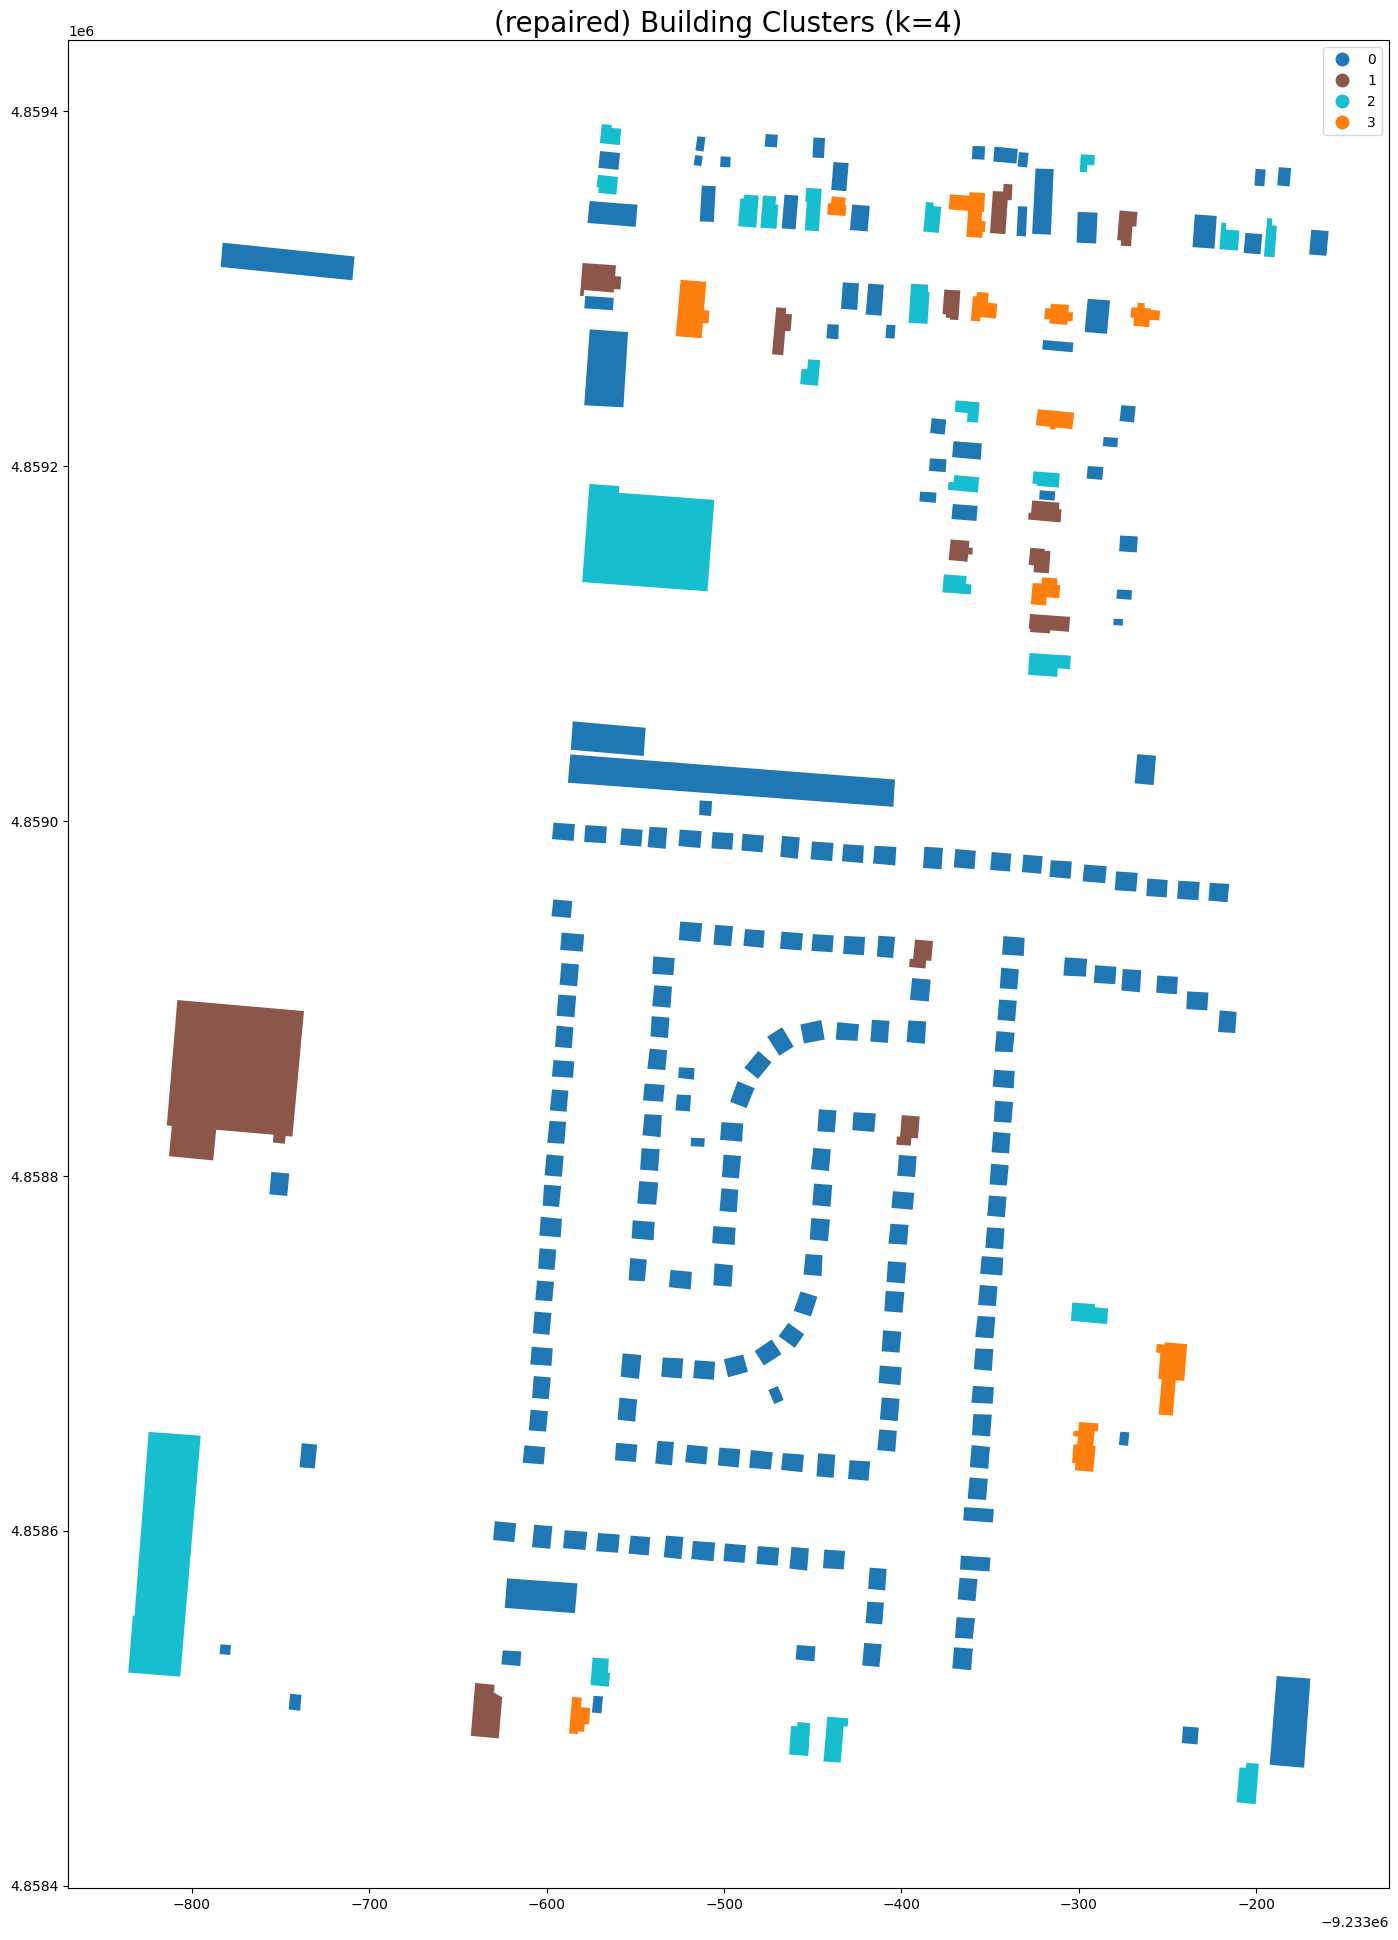

In [416]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# get the tab10 colormap
tab10 = cm.get_cmap('tab10')
# specify the colors
colors = [tab10(0), tab10(5), tab10(9), tab10(1)]
custom_cmap = ListedColormap(colors)

sim_buildings_ext_gdf.plot(column='cluster_4', cmap=custom_cmap, legend=True, figsize=(24,24))
plt.title("(repaired) Building Clusters (k=4)", fontsize=20)